In [1]:
# Load library
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
import h5py
import time
from sklearn import multioutput
import xgboost as xgb

In [2]:
# Seed
np.random.seed(10)
tf.random.set_seed(10)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763


In [5]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763/Data')
Data1 = loadmat('p5763_Set1_Inputs.mat')
Data2 = loadmat('p5763_Set1_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df1 = df[['Time','K','V','AE','Amp','SS','TTF','ln_V_V0']]
sr = df1[['Time','ln_V_V0']]
df1 = df1[['K','V','AE','Amp','SS','TTF','Time']]
df2 = df1.merge(sr,on = 'Time')
df_SS = df2[['K','V','AE','Amp','SS']]
df_TTF = df2[['K','V','AE','Amp','TTF']]
xdf = df[['K','V','AE','Amp']]
ydf = df[['SS','TTF']]

print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
             K      V    AE      Amp
0     5957.24  17.78  2.00  2090.29
1     5960.89  17.79  2.00  2072.79
2     6214.84  17.81  2.00  2078.77
3     4543.97  17.74  2.00  2085.99
4     4554.15  17.76  1.67  2066.37
...       ...    ...   ...      ...
9495  1033.99  16.82  2.00  1720.64
9496  1032.72  16.81  2.00  1742.58
9497  1032.13  16.81  1.67  1732.37
9498  1032.36  16.81  1.67  1693.09
9499  1114.37  16.83  1.50  1704.66

[9500 rows x 4 columns]
Target Data:
         SS   TTF
0     6.05  0.00
1     6.06  0.00
2     6.06  0.00
3     6.07  0.00
4     6.07  0.00
...    ...   ...
9495  5.92  6.55
9496  5.92  6.45
9497  5.93  6.34
9498  5.93  6.23
9499  5.94  6.12

[9500 rows x 2 columns]


In [6]:
# History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [7]:
# Preprocessing
arr = df_SS.to_numpy()
n_steps = 100
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing
arr = df_TTF.to_numpy()
n_steps = 100
xdf, ydf_TTF = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, SS = ', np.shape(ydf_SS))
print('Target shape, TTF = ', np.shape(ydf_TTF))

# Reshape features from 3D to 2D

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (9400, 100, 4)
Target shape, SS =  (9400,)
Target shape, TTF =  (9400,)
After reshaping, X =  (9400, 400)


In [8]:
# Split into train-val-test
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, random_state = 0, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, random_state = 0, test_size=0.111, shuffle=False)

# Split into train-val-test
x_train, x_test, y_train_TTF, y_test_TTF = train_test_split(xdf, ydf_TTF, random_state = 0, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_TTF, Y_val_TTF = train_test_split(x_train, y_train_TTF, random_state = 0, test_size=0.111, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training input samples:", np.shape(X_train))
print("Validation input samples:", np.shape(X_val))
print("Testing input samples:", np.shape(x_test))

print("Training output samples SS:", np.shape(Y_train_SS))
print("Validation output samples SS:", np.shape(Y_val_SS))
print("Testing output samples SS:", np.shape(y_test_SS))

print("Training output samples TTF:", np.shape(Y_train_TTF))
print("Validation output samples TTF:", np.shape(Y_val_TTF))
print("Testing output samples TTF:", np.shape(y_test_TTF))

Training input samples: (7520, 400)
Validation input samples: (940, 400)
Testing input samples: (940, 400)
Training output samples SS: (7520,)
Validation output samples SS: (940,)
Testing output samples SS: (940,)
Training output samples TTF: (7520,)
Validation output samples TTF: (940,)
Testing output samples TTF: (940,)


In [9]:
# # Parameter tuning

# params = {
#         'learning_rate': [0.01, 0.1, 0.5],
#         'n_estimators': [200, 600, 1000],
#         'max_depth': [3, 6, 9],
#         'objective':['reg:squarederror']
#         }

# best_score = 0

# for g in ParameterGrid(params):
#   model = XGBRegressor()
#   model.set_params(**g)
#   model.fit(X_train, Y_train_SS)
#   y_predVal = model.predict(X_val)
#   val_r2 = r2_score(Y_val_SS, y_predVal)
#   if val_r2 > best_score:
#     best_score = val_r2
#     best_grid = g
# #print(best_grid)

In [10]:
# Train the model
model = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=600)
start_time = time.time()
model.fit(X_train, Y_train_SS, eval_set=[(X_val, Y_val_SS)],early_stopping_rounds=20)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.16019
[1]	validation_0-rmse:0.15913
[2]	validation_0-rmse:0.15813
[3]	validation_0-rmse:0.15688
[4]	validation_0-rmse:0.15587
[5]	validation_0-rmse:0.15464
[6]	validation_0-rmse:0.15371
[7]	validation_0-rmse:0.15274
[8]	validation_0-rmse:0.15160
[9]	validation_0-rmse:0.15070
[10]	validation_0-rmse:0.14976
[11]	validation_0-rmse:0.14884
[12]	validation_0-rmse:0.14794
[13]	validation_0-rmse:0.14707
[14]	validation_0-rmse:0.14599
[15]	validation_0-rmse:0.14486
[16]	validation_0-rmse:0.14383
[17]	validation_0-rmse:0.14295
[18]	validation_0-rmse:0.14191
[19]	validation_0-rmse:0.14107
[20]	validation_0-rmse:0.13999
[21]	validation_0-rmse:0.13943
[22]	validation_0-rmse:0.13839
[23]	validation_0-rmse:0.13737
[24]	validation_0-rmse:0.13636
[25]	validation_0-rmse:0.13580
[26]	validation_0-rmse:0.13482
[27]	validation_0-rmse:0.13386
[28]	validation_0-rmse:0.13290
[29]	validation_0-rmse:0.13196
[30]	validation_0-rmse:0.13098
[31]	validation_0-rmse:0.13009
[32]	validation_0-

In [11]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))

ss_train_r2 = r2_score(Y_train_SS, y_predTrain)
ss_train_rmse = np.sqrt(mean_squared_error(Y_train_SS, y_predTrain))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))

ss_val_r2 = r2_score(Y_val_SS, y_predVal)
ss_val_rmse = np.sqrt(mean_squared_error(Y_val_SS, y_predVal))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))

ss_test_r2 = r2_score(y_test_SS, y_predTest)
ss_test_rmse = np.sqrt(mean_squared_error(y_test_SS, y_predTest))

## Print
print('Shear Stress')
print('R2 score:', ss_train_r2, ss_val_r2 ,ss_test_r2, '\nRMSE:', ss_train_rmse, ss_val_rmse ,ss_test_rmse)

Shear Stress
R2 score: 0.9928297817080141 0.8985837321616048 0.8317914395122065 
RMSE: 0.011454080495445535 0.04943346896548794 0.06211013718458858


Text(0.5, 1.0, 'XGBoost: Shear Stress Prediction')

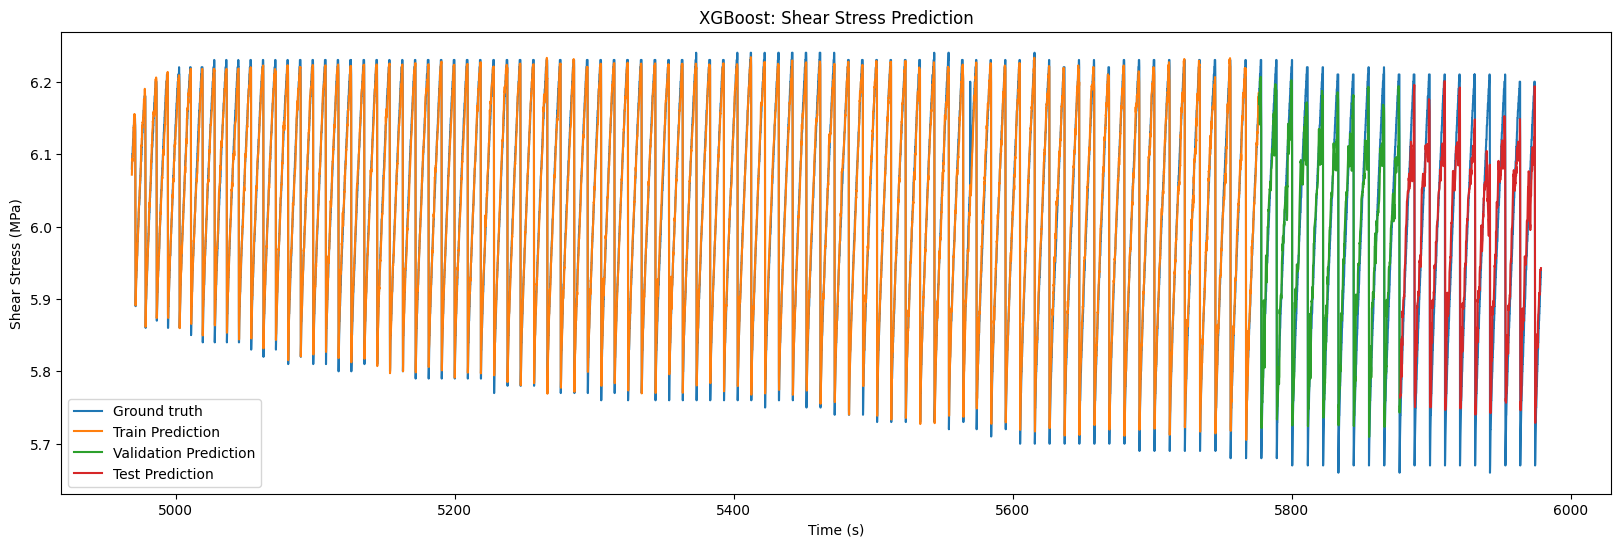

In [12]:
# Overall plot: SS
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predTrain.iloc[:,0])
plt.plot(valtime, y_predVal.iloc[:,0])
plt.plot(testtime, y_predTest.iloc[:,0])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: Shear Stress Prediction')

In [13]:
# # Parameter tuning

# params = {
#         'learning_rate': [0.01, 0.1, 0.5],
#         'n_estimators': [200, 600, 1000],
#         'max_depth': [3, 6, 9],
#         'objective':['reg:squarederror']
#         }

# best_score = 0

# for g in ParameterGrid(params):
#   model = XGBRegressor()
#   model.set_params(**g)
#   model.fit(X_train, Y_train_TTF)
#   y_predVal = model.predict(X_val)
#   val_r2 = r2_score(Y_val_TTF, y_predVal)
#   if val_r2 > best_score:
#     best_score = val_r2
#     best_grid = g
# #print(best_grid)

In [14]:
# Train the model
model = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=600)
start_time = time.time()
model.fit(X_train, Y_train_TTF, eval_set=[(X_val, Y_val_TTF)],early_stopping_rounds=20)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:3.26891
[1]	validation_0-rmse:3.24636
[2]	validation_0-rmse:3.21979
[3]	validation_0-rmse:3.19891
[4]	validation_0-rmse:3.17316
[5]	validation_0-rmse:3.14844
[6]	validation_0-rmse:3.12800
[7]	validation_0-rmse:3.10259
[8]	validation_0-rmse:3.08355
[9]	validation_0-rmse:3.05866
[10]	validation_0-rmse:3.03532
[11]	validation_0-rmse:3.01630
[12]	validation_0-rmse:2.99119
[13]	validation_0-rmse:2.96858
[14]	validation_0-rmse:2.94452
[15]	validation_0-rmse:2.92483
[16]	validation_0-rmse:2.90271
[17]	validation_0-rmse:2.87989
[18]	validation_0-rmse:2.85776
[19]	validation_0-rmse:2.84015
[20]	validation_0-rmse:2.81769
[21]	validation_0-rmse:2.79537
[22]	validation_0-rmse:2.77429
[23]	validation_0-rmse:2.75263
[24]	validation_0-rmse:2.73120
[25]	validation_0-rmse:2.70844
[26]	validation_0-rmse:2.68914
[27]	validation_0-rmse:2.66887
[28]	validation_0-rmse:2.64691
[29]	validation_0-rmse:2.62618
[30]	validation_0-rmse:2.60597
[31]	validation_0-rmse:2.58501
[32]	validation_0-

In [15]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))

ttf_train_r2 = r2_score(Y_train_TTF, y_predTrain)
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train_TTF, y_predTrain))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))

ttf_val_r2 = r2_score(Y_val_TTF, y_predVal)
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val_TTF, y_predVal))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))

ttf_test_r2 = r2_score(y_test_TTF, y_predTest)
ttf_test_rmse = np.sqrt(mean_squared_error(y_test_TTF, y_predTest))

## Print
print('\nTTF')
print('R2 score:', ttf_train_r2, ttf_val_r2, ttf_test_r2, '\nRMSE:', ttf_train_rmse, ttf_val_rmse , ttf_test_rmse)


TTF
R2 score: 0.9953416108583062 0.9326704779577147 0.8565589555070334 
RMSE: 0.1954909205737514 0.8341469719290912 1.1769197802084908


Text(0.5, 1.0, 'XGBoost: TTF Prediction')

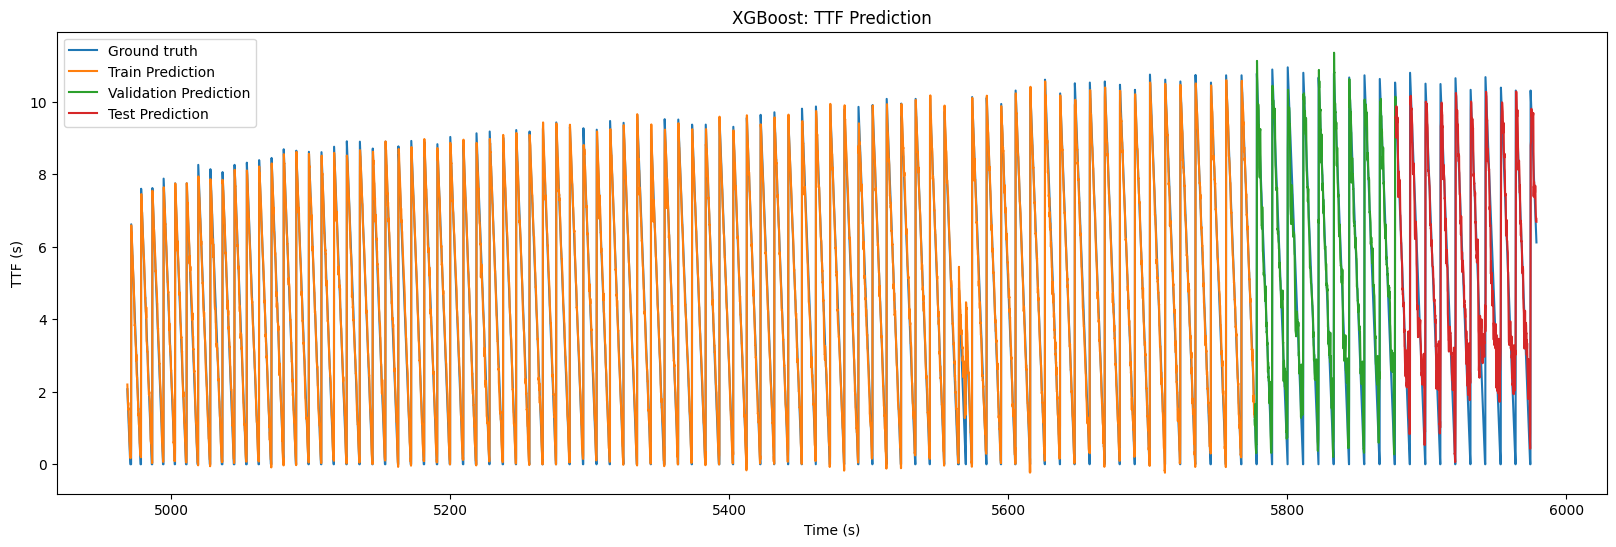

In [16]:
# Overall plot: TTF
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

## TTF
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_TTF)
plt.plot(traintime, y_predTrain.iloc[:,0])
plt.plot(valtime, y_predVal.iloc[:,0])
plt.plot(testtime, y_predTest.iloc[:,0])
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: TTF Prediction')

In [17]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763/Data')
Data1 = loadmat('p5763_Set1_Inputs.mat')
Data2 = loadmat('p5763_Set1_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df1 = df[['Time','K','V','AE','Amp','SS','TTF','ln_V_V0']]
sr = df1[['Time','ln_V_V0']]
df1 = df1[['K','V','AE','Amp','SS','TTF','Time']]
df2 = df1.merge(sr,on = 'Time')
df = df2[['AE','ln_V_V0']]
xdf = df[['AE']]
ydf = df[['ln_V_V0']]

print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         AE
0     2.00
1     2.00
2     2.00
3     2.00
4     1.67
...    ...
9495  2.00
9496  2.00
9497  1.67
9498  1.67
9499  1.50

[9500 rows x 1 columns]
Target Data:
       ln_V_V0
0      -11.51
1      -11.51
2      -11.51
3      -11.51
4      -11.51
...       ...
9495   -11.51
9496   -11.51
9497   -11.51
9498   -11.51
9499   -11.51

[9500 rows x 1 columns]


In [18]:
# History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1:]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [19]:
# Preprocessing
arr = df.to_numpy()
n_steps = 100
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (9400, 100, 1)
Target shape, Y =  (9400, 1)
After reshaping, X =  (9400, 100)


In [20]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, random_state = 0, test_size=0.1, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, random_state = 0, test_size=0.111, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training input samples:", np.shape(X_train))
print("Validation input samples:", np.shape(X_val))
print("Testing input samples:", np.shape(x_test))

print("Training output samples:", np.shape(Y_train))
print("Validation output samples:", np.shape(Y_val))
print("Testing output samples:", np.shape(y_test))

Training input samples: (7520, 100)
Validation input samples: (940, 100)
Testing input samples: (940, 100)
Training output samples: (7520, 1)
Validation output samples: (940, 1)
Testing output samples: (940, 1)


In [21]:
# # Parameter tuning

# params = {
#         'learning_rate': [0.01, 0.1, 0.5],
#         'n_estimators': [200, 600, 1000],
#         'max_depth': [3, 6, 9],
#         'objective':['reg:squarederror']
#         }

# best_score = 0

# for g in ParameterGrid(params):
#   model = XGBRegressor()
#   model.set_params(**g)
#   model.fit(X_train, Y_train_SR)
#   y_predVal = model.predict(X_val)
#   val_r2 = r2_score(Y_val_SR, y_predVal)
#   if val_r2 > best_score:
#     best_score = val_r2
#     best_grid = g
# #print(best_grid)

In [23]:
# Train the model
model = XGBRegressor(learning_rate=0.01, max_depth=6, n_estimators=600)
start_time = time.time()
model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)],early_stopping_rounds=20)
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

[0]	validation_0-rmse:1.42982
[1]	validation_0-rmse:1.41963
[2]	validation_0-rmse:1.40957
[3]	validation_0-rmse:1.39963
[4]	validation_0-rmse:1.38981
[5]	validation_0-rmse:1.38012
[6]	validation_0-rmse:1.37055
[7]	validation_0-rmse:1.36110
[8]	validation_0-rmse:1.35178


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-rmse:1.34256
[10]	validation_0-rmse:1.33347
[11]	validation_0-rmse:1.32449
[12]	validation_0-rmse:1.31563
[13]	validation_0-rmse:1.30688
[14]	validation_0-rmse:1.29825
[15]	validation_0-rmse:1.28972
[16]	validation_0-rmse:1.28116
[17]	validation_0-rmse:1.27286
[18]	validation_0-rmse:1.26452
[19]	validation_0-rmse:1.25629
[20]	validation_0-rmse:1.24830
[21]	validation_0-rmse:1.24029
[22]	validation_0-rmse:1.23238
[23]	validation_0-rmse:1.22471
[24]	validation_0-rmse:1.21700
[25]	validation_0-rmse:1.20940
[26]	validation_0-rmse:1.20191
[27]	validation_0-rmse:1.19464
[28]	validation_0-rmse:1.18734
[29]	validation_0-rmse:1.18014
[30]	validation_0-rmse:1.17316
[31]	validation_0-rmse:1.16615
[32]	validation_0-rmse:1.15924
[33]	validation_0-rmse:1.15254
[34]	validation_0-rmse:1.14582
[35]	validation_0-rmse:1.13919
[36]	validation_0-rmse:1.13277
[37]	validation_0-rmse:1.12632
[38]	validation_0-rmse:1.12086
[39]	validation_0-rmse:1.11459
[40]	validation_0-rmse:1.10929
[41]	vali

In [24]:
# Evaluate the model

## Training
y_predTrain = pd.DataFrame(model.predict(X_train))
sr_train_r2 = r2_score(Y_train, y_predTrain)
sr_train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

## Validation
y_predVal = pd.DataFrame(model.predict(X_val))
sr_val_r2 = r2_score(Y_val, y_predVal)
sr_val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))

## Testing
y_predTest = pd.DataFrame(model.predict(x_test))
sr_test_r2 = r2_score(y_test, y_predTest)
sr_test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

## Print
print('\nSlip rate')
print('R2 score:', sr_train_r2, sr_val_r2, sr_test_r2, '\nRMSE:', sr_train_rmse, sr_val_rmse , sr_test_rmse)


Slip rate
R2 score: 0.9989983395122615 0.7803438633845275 0.9420262654020772 
RMSE: 0.046485842409790624 0.6749469607697636 0.3316231273559484


Text(0.5, 1.0, 'XGBoost: Slip Rate Prediction')

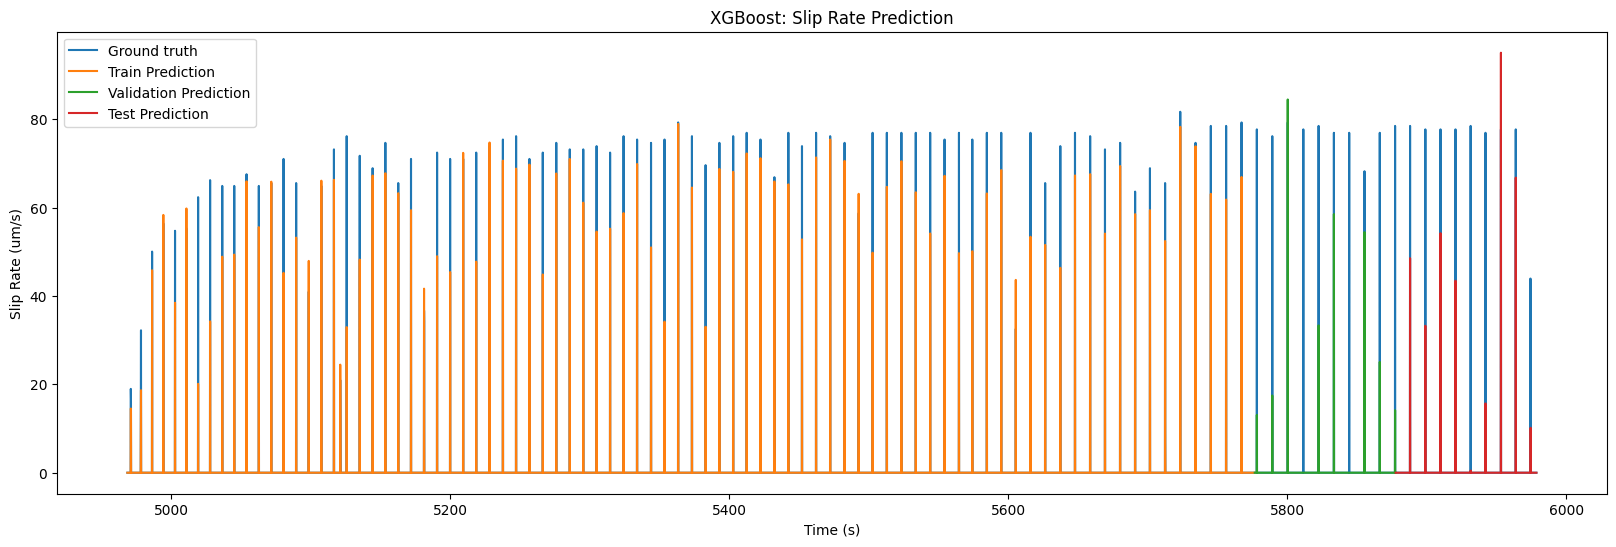

In [25]:
# Overall plot: Slip Rate
ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

# Scale
ydf_scale = ydf
ydf_scale = np.exp(ydf_scale)*10;

y_predTrain_scale = y_predTrain
y_predTrain_scale = np.exp(y_predTrain_scale)*10;

y_predVal_scale = y_predVal
y_predVal_scale = np.exp(y_predVal_scale)*10;

y_predTest_scale = y_predTest
y_predTest_scale = np.exp(y_predTest_scale)*10;

## SR
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_scale)
plt.plot(traintime, y_predTrain_scale)
plt.plot(valtime, y_predVal_scale)
plt.plot(testtime, y_predTest_scale)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('XGBoost: Slip Rate Prediction')